# Определение перспективного тарифа для телеком компании

### Описание проекта

В компании оператора сотовой связи, клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

#### Тариф «Смарт»

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:  
   - минута разговора: 3 рубля
   - сообщение: 3 рубля
   - 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   - минута разговора: 1 рубль
   - сообщение: 1 рубль
   - 1 Гб интернет-трафика: 150 рублей

## Шаг 1.Файл с данными

### Описание данных

Таблица *users* (информация о пользователях):  
- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tariff* — название тарифного плана

Таблица *calls* (информация о звонках):
- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

Таблица *messages* (информация о сообщениях):
- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

Таблица *internet* (информация об интернет-сессиях):
- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

Таблица *tariffs* (информация о тарифах):
- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [40]:
import pandas as pd
import numpy as np
import math
from scipy import stats as st
from matplotlib import pyplot as plt

calls = pd.read_csv('/datasets/calls.csv')
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [41]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице нет пропусков, однако в столбце duration есть нулевые значения, вероятнее всего пользователи сбрасывали трубку. Столбец call_date надо преобразовать в тип datetime. Посмотрим следующую таблицу.

In [42]:
internet = pd.read_csv('/datasets/internet.csv')
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [43]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Также нет пропусков, но присутствуют нулевые значения в объеме потраченного за сессию интернет-трафика, если пользователь не пользовался в такую сессию интернетом, скорее всего это выбросы и учитывать такие строки не будем. session_date надо перевести в datetime.

In [44]:
messages = pd.read_csv('/datasets/messages.csv')
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [45]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Нет пустых значений, message_date - в datetime.

In [46]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [47]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [48]:
users = pd.read_csv('/datasets/users.csv')
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [49]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Пропущенные значения в столбце churn_date объясняются тем, что тариф еще действовал на момент выгрузки данных. Столбцы с датой логично перевести в тип datetime.

### Вывод

Во всех таблицах не обнаружено пропусков, кроме стобца churn_date в users, так как в нем указывается информация о прекращении пользования тарифом, а у большества пользователей тариф мог еще действовать в момент выгрузки. Однако существуют нулевые значения в столбцах duration и mb_used в таблицах calls и internet соответственно. Такие значения надо обработать либо удалить. Также необходимо перевести все столбцы с датами из строки в тип datetime.

## Шаг 2. Предобработка данных

In [50]:
internet.query('mb_used == 0')['id'].count()

19598

In [51]:
calls.query('duration == 0')['id'].count()

39613

In [52]:
#заполнение средними значениями или медианой может повлиять на распределение величин, лучше удалить такие строки.
internet = internet.loc[internet.loc[:, 'mb_used'] != 0]
calls = calls.loc[calls.loc[:, 'duration'] != 0]

In [53]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null object
duration     162994 non-null float64
user_id      162994 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [54]:
#приведем даты к нужным типам.
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
# выделим месяц в отдельный столбец
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
#округление времени звонка в большую сторону, по правилам компании
calls['duration'] = calls['duration'].apply(np.ceil) 
calls

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9
...,...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499,12
202603,1499_216,2018-10-18,19.0,1499,10
202604,1499_217,2018-11-10,11.0,1499,11
202605,1499_218,2018-10-06,5.0,1499,10


In [57]:
# количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя
every_users_calls = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
every_users_calls.columns = ['count_calls', 'duration_sum']
every_users_calls

count_calls  duration_sum
user_id month                           
1000    5               17         159.0
        6               28         172.0
        7               41         340.0
        8               42         408.0
        9               46         466.0
...                    ...           ...
1498    10              30         247.0
1499    9                8          70.0
        10              44         449.0
        11              62         612.0
        12              56         492.0

[3168 rows x 2 columns]

In [58]:
# количество отправленных сообщений по месяцам для каждого пользователя
every_users_messages = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
every_users_messages.columns = ['count_messages']
every_users_messages

count_messages
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

In [59]:
# объем израсходованного интернет-трафика по месяцам для каждого пользователя
every_users_internet = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
every_users_internet.columns = ['sum_mb_used']
every_users_internet

sum_mb_used
user_id month             
1000    5          2253.49
        6         23233.77
        7         14003.64
        8         14055.93
        9         14568.91
...                    ...
1498    10        20579.36
1499    9          1845.75
        10        17788.51
        11        17963.31
        12        13055.58

[3201 rows x 1 columns]

In [60]:
# объединим три сводные таблицы в одну
all_for_every_users = every_users_calls.join([every_users_messages, every_users_internet], how='outer')
all_for_every_users

count_calls  duration_sum  count_messages  sum_mb_used
user_id month                                                        
1000    5             17.0         159.0            22.0      2253.49
        6             28.0         172.0            60.0     23233.77
        7             41.0         340.0            75.0     14003.64
        8             42.0         408.0            81.0     14055.93
        9             46.0         466.0            57.0     14568.91
...                    ...           ...             ...          ...
1498    10            30.0         247.0            42.0     20579.36
1499    9              8.0          70.0            11.0      1845.75
        10            44.0         449.0            48.0     17788.51
        11            62.0         612.0            59.0     17963.31
        12            56.0         492.0            66.0     13055.58

[3214 rows x 4 columns]

In [61]:
# столбец sum_gb сумма гигов, округленная в большую сторону
all_for_every_users['sum_gb'] = (all_for_every_users['sum_mb_used'] / 1024).apply(np.ceil).astype('Int64')
all_for_every_users

count_calls  duration_sum  count_messages  sum_mb_used  sum_gb
user_id month                                                                
1000    5             17.0         159.0            22.0      2253.49       3
        6             28.0         172.0            60.0     23233.77      23
        7             41.0         340.0            75.0     14003.64      14
        8             42.0         408.0            81.0     14055.93      14
        9             46.0         466.0            57.0     14568.91      15
...                    ...           ...             ...          ...     ...
1498    10            30.0         247.0            42.0     20579.36      21
1499    9              8.0          70.0            11.0      1845.75       2
        10            44.0         449.0            48.0     17788.51      18
        11            62.0         612.0            59.0     17963.31      18
        12            56.0         492.0            66.0     13055.58      13

[3214 rows x 5 columns]

In [62]:
#месяц из мультииндекса
all_for_every_users['month'] = all_for_every_users.index.get_level_values(1) 
all_for_every_users

count_calls  duration_sum  count_messages  sum_mb_used  sum_gb  \
user_id month                                                                   
1000    5             17.0         159.0            22.0      2253.49       3   
        6             28.0         172.0            60.0     23233.77      23   
        7             41.0         340.0            75.0     14003.64      14   
        8             42.0         408.0            81.0     14055.93      14   
        9             46.0         466.0            57.0     14568.91      15   
...                    ...           ...             ...          ...     ...   
1498    10            30.0         247.0            42.0     20579.36      21   
1499    9              8.0          70.0            11.0      1845.75       2   
        10            44.0         449.0            48.0     17788.51      18   
        11            62.0         612.0            59.0     17963.31      18   
        12            56.0         492.0            66.0     13055.58      13   

               month  
user_id month         
1000    5          5  
        6          6  
        7          7  
        8          8  
        9          9  
...              ...  
1498    10        10  
1499    9          9  
        10        10  
        11        11  
        12        12  

[3214 rows x 6 columns]

In [63]:
#добавление столбца tariff из таблицы users
all_for_every_users = all_for_every_users.merge(users[['user_id','tariff', 'city']], on='user_id') 
all_for_every_users

,user_id,count_calls,duration_sum,count_messages,sum_mb_used,sum_gb,month,tariff,city
0,1000,17.0,159.0,22.0,2253.49,3,5,ultra,Краснодар
1,1000,28.0,172.0,60.0,23233.77,23,6,ultra,Краснодар
2,1000,41.0,340.0,75.0,14003.64,14,7,ultra,Краснодар
3,1000,42.0,408.0,81.0,14055.93,14,8,ultra,Краснодар
4,1000,46.0,466.0,57.0,14568.91,15,9,ultra,Краснодар
...,...,...,...,...,...,...,...,...,...
3209,1498,30.0,247.0,42.0,20579.36,21,10,smart,Владикавказ
3210,1499,8.0,70.0,11.0,1845.75,2,9,smart,Пермь
3211,1499,44.0,449.0,48.0,17788.51,18,10,smart,Пермь
3212,1499,62.0,612.0,59.0,17963.31,18,11,smart,Пермь


In [64]:
#абонентская плата за тариф ultra
rub_monthly_fee_ultra = tariffs[tariffs['tariff_name'] == 'ultra']['rub_monthly_fee'].values[0]
#количество минут разговора в месяц, включённых в абонентскую плату ultra
minutes_included_ultra = tariffs[tariffs['tariff_name'] == 'ultra']['minutes_included'].values[0]
#количество сообщений в месяц, включённых в абонентскую плату ultra
messages_included_ultra = tariffs[tariffs['tariff_name'] == 'ultra']['messages_included'].values[0]
#объём интернет-трафика, включённого в абонентскую плату (в гигабайтах)
mb_per_month_included_ultra = ((tariffs[tariffs['tariff_name'] == 'ultra']['mb_per_month_included']) / 1024).values[0]
# стоимость минуты разговора сверх тарифного пакета ultra
rub_per_minute_ultra = tariffs[tariffs['tariff_name'] == 'ultra']['rub_per_minute'].values[0]
#стоимость отправки сообщения сверх тарифного пакета ultra
rub_per_message_ultra = tariffs[tariffs['tariff_name'] == 'ultra']['rub_per_message'].values[0]
#стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета ultra
rub_per_gb_ultra = tariffs[tariffs['tariff_name'] == 'ultra']['rub_per_gb'].values[0] 

In [65]:
#абонентская плата за тариф smart и дальше по аналогии с ultra
rub_monthly_fee_smart = tariffs[tariffs['tariff_name'] == 'smart']['rub_monthly_fee'].values[0] 
minutes_included_smart = tariffs[tariffs['tariff_name'] == 'smart']['minutes_included'].values[0]
messages_included_smart = tariffs[tariffs['tariff_name'] == 'smart']['messages_included'].values[0]
mb_per_month_included_smart = ((tariffs[tariffs['tariff_name'] == 'smart']['mb_per_month_included']) / 1024).values[0]
rub_per_minute_smart = tariffs[tariffs['tariff_name'] == 'smart']['rub_per_minute'].values[0]
rub_per_message_smart = tariffs[tariffs['tariff_name'] == 'smart']['rub_per_message'].values[0]
rub_per_gb_smart = tariffs[tariffs['tariff_name'] == 'smart']['rub_per_gb'].values[0]

In [66]:
minutes_included_ultra

3000

In [67]:
#функция profit_tar считает помесячную выручку для разных тарифов:
# прибавляет к абонентской плате выручку сверх тарифного плана, если таковая была
def profit_tar(data):
    if data['tariff'] == 'ultra': 
        profit = rub_monthly_fee_ultra
        if data['duration_sum'] - minutes_included_ultra > 0:
            profit += (data['duration_sum'] - minutes_included_ultra) * rub_per_minute_ultra
        if data['count_messages'] - messages_included_ultra > 0:
            profit += (data['count_messages'] - messages_included_ultra) * rub_per_message_ultra
        if data['sum_gb'] - mb_per_month_included_ultra > 0:
            profit += (data['sum_gb'] - mb_per_month_included_ultra) * rub_per_gb_ultra
    if data['tariff'] == 'smart':
        profit = rub_monthly_fee_smart
        if data['duration_sum'] - minutes_included_smart > 0:
            profit += (data['duration_sum'] - minutes_included_smart) * rub_per_minute_smart
        if data['count_messages'] - messages_included_smart > 0:
            profit += (data['count_messages'] - messages_included_smart) * rub_per_message_smart
        if data['sum_gb'] - mb_per_month_included_smart > 0:
            profit += (data['sum_gb'] - mb_per_month_included_smart) * rub_per_gb_smart
    return profit
        
        
all_for_every_users['profit'] = all_for_every_users.apply(profit_tar, axis=1)
all_for_every_users

,user_id,count_calls,duration_sum,count_messages,sum_mb_used,sum_gb,month,tariff,city,profit
0,1000,17.0,159.0,22.0,2253.49,3,5,ultra,Краснодар,1950.0
1,1000,28.0,172.0,60.0,23233.77,23,6,ultra,Краснодар,1950.0
2,1000,41.0,340.0,75.0,14003.64,14,7,ultra,Краснодар,1950.0
3,1000,42.0,408.0,81.0,14055.93,14,8,ultra,Краснодар,1950.0
4,1000,46.0,466.0,57.0,14568.91,15,9,ultra,Краснодар,1950.0
...,...,...,...,...,...,...,...,...,...,...
3209,1498,30.0,247.0,42.0,20579.36,21,10,smart,Владикавказ,1750.0
3210,1499,8.0,70.0,11.0,1845.75,2,9,smart,Пермь,550.0
3211,1499,44.0,449.0,48.0,17788.51,18,10,smart,Пермь,1150.0
3212,1499,62.0,612.0,59.0,17963.31,18,11,smart,Пермь,1513.0


### Вывод

Данные приведены к нужным форматам. Собрана таблица для дальнейшего анализа данных, в которой посчитана помесячная выручка с каждого пользователя.

## Шаг 3. Анализ данных

In [68]:
# Разобьем таблицу all_for_every_users на две по тарифам
all_for_every_users_ultra = all_for_every_users.loc[all_for_every_users.loc[:, 'tariff'] == 'ultra']
all_for_every_users_ultra

,user_id,count_calls,duration_sum,count_messages,sum_mb_used,sum_gb,month,tariff,city,profit
0,1000,17.0,159.0,22.0,2253.49,3,5,ultra,Краснодар,1950.0
1,1000,28.0,172.0,60.0,23233.77,23,6,ultra,Краснодар,1950.0
2,1000,41.0,340.0,75.0,14003.64,14,7,ultra,Краснодар,1950.0
3,1000,42.0,408.0,81.0,14055.93,14,8,ultra,Краснодар,1950.0
4,1000,46.0,466.0,57.0,14568.91,15,9,ultra,Краснодар,1950.0
...,...,...,...,...,...,...,...,...,...,...
3186,1495,13.0,92.0,13.0,2614.07,3,8,ultra,Иркутск,1950.0
3187,1495,95.0,813.0,82.0,33067.62,33,9,ultra,Иркутск,2400.0
3188,1495,126.0,1030.0,82.0,29363.00,29,10,ultra,Иркутск,1950.0
3189,1495,112.0,954.0,79.0,38939.11,39,11,ultra,Иркутск,3300.0


In [69]:
all_for_every_users_smart = all_for_every_users.loc[all_for_every_users.loc[:, 'tariff'] == 'smart']
all_for_every_users_smart

,user_id,count_calls,duration_sum,count_messages,sum_mb_used,sum_gb,month,tariff,city,profit
8,1001,45.0,430.0,NaN,18429.34,18,11,smart,Москва,1150.0
9,1001,47.0,414.0,NaN,14036.66,14,12,smart,Москва,550.0
10,1002,14.0,117.0,4.0,10856.82,11,6,smart,Стерлитамак,550.0
11,1002,21.0,214.0,11.0,17580.10,18,7,smart,Стерлитамак,1150.0
12,1002,37.0,289.0,13.0,20319.26,20,8,smart,Стерлитамак,1550.0
...,...,...,...,...,...,...,...,...,...,...
3209,1498,30.0,247.0,42.0,20579.36,21,10,smart,Владикавказ,1750.0
3210,1499,8.0,70.0,11.0,1845.75,2,9,smart,Пермь,550.0
3211,1499,44.0,449.0,48.0,17788.51,18,10,smart,Пермь,1150.0
3212,1499,62.0,612.0,59.0,17963.31,18,11,smart,Пермь,1513.0


Найдем средние значения количества минут звонков, количества сообщений и объема интернет-трафика по месяцам для тарифа ultra.

In [70]:
duration_sum_mean_ultra = all_for_every_users_ultra['duration_sum'].mean()
print('средняя сумма минут разговора в месяц:', duration_sum_mean_ultra)
count_messages_mean_ultra = all_for_every_users_ultra['count_messages'].mean()
print('среднее число сообщений', count_messages_mean_ultra)
sum_gb_mean_ultra = all_for_every_users_ultra['sum_gb'].mean()
sum_gb_mean_ultra

средняя сумма минут разговора в месяц: 547.7550158394931
среднее число сообщений 61.161006289308176


19.71457905544148

Для тех же величин найдем дисперсию.

In [71]:
duration_sum_var_ultra = np.var(all_for_every_users_ultra['duration_sum'], ddof=1)
print('дисперсия суммы минут звонков', duration_sum_var_ultra)
count_messages_var_ultra = np.var(all_for_every_users_ultra['count_messages'], ddof=1)
print('дисперсия числа сообщений', count_messages_var_ultra)
sum_gb_var_ultra = np.var(all_for_every_users_ultra['sum_gb'], ddof=1)
sum_gb_var_ultra

дисперсия суммы минут звонков 93338.42829141096
дисперсия числа сообщений 2109.6591828651995


93.84445321419601

Посчитаем стандартное отклонение.

In [72]:
duration_sum_sto_ultra = math.sqrt(duration_sum_var_ultra)
print('стандартное отклонение для суммы минут звонков:', duration_sum_sto_ultra)
count_messages_sto_ultra = math.sqrt(count_messages_var_ultra)
print('сто для сообщений:', count_messages_sto_ultra)
sum_gb_sto_ultra = math.sqrt(sum_gb_var_ultra)
sum_gb_sto_ultra

стандартное отклонение для суммы минут звонков: 305.5133847991131
сто для сообщений: 45.93102636416042


9.687334680612413

Тоже самое для тарифа smart.

In [73]:
duration_sum_mean_smart = all_for_every_users_smart['duration_sum'].mean()
print('срееднее суммы минут звонков:', duration_sum_mean_smart)
count_messages_mean_smart = all_for_every_users_smart['count_messages'].mean()
print('среднее количества сообщений:', count_messages_mean_smart)
sum_gb_mean_smart = all_for_every_users_smart['sum_gb'].mean()
sum_gb_mean_smart

срееднее суммы минут звонков: 419.4403421882035
среднее количества сообщений: 38.71644120707596


16.34351145038168

In [74]:
duration_sum_var_smart = np.var(all_for_every_users_smart['duration_sum'], ddof=1)
print('дисперсия суммы минут звонов:', duration_sum_var_smart)
count_messages_var_smart = np.var(all_for_every_users_smart['count_messages'], ddof=1)
print('дисперсия числа сообщений:', count_messages_var_smart)
sum_gb_var_smart = np.var(all_for_every_users_smart['sum_gb'], ddof=1)
sum_gb_var_smart

дисперсия суммы минут звонов: 35718.128533936906
дисперсия числа сообщений: 717.5942011753547


32.81860455546182

In [75]:
duration_sum_sto_smart = math.sqrt(duration_sum_var_smart)
print('сто суммы минут звонков:', duration_sum_sto_smart)
count_messages_sto_smart = math.sqrt(count_messages_var_smart)
print('сто числа сообщений:', count_messages_sto_smart)
sum_gb_sto_smart = math.sqrt(sum_gb_var_smart)
sum_gb_sto_smart

сто суммы минут звонков: 188.99240337626512
сто числа сообщений: 26.787948804926344


5.728752443199289

Cреднии значения тарифа ultra выше, что логично, потому что пользователи берут более дорогой тариф, чтобы расходовать большее количество минут звонков, сообщений и интернет-трафика. Однако разброс значений у тарифа ultra больше чем у smart.  
Построим гистограммы для данных величин.

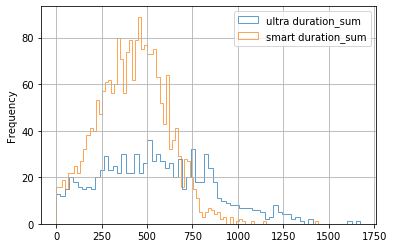

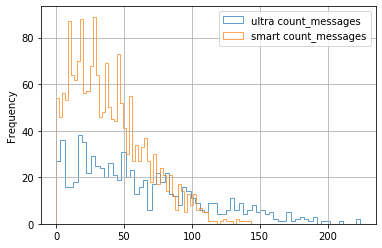

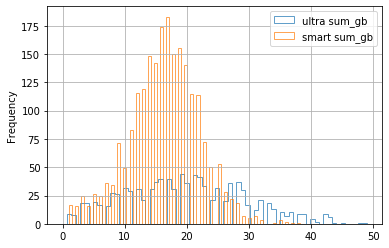

In [76]:
columns_for_hist = ['duration_sum', 'count_messages', 'sum_gb']

for column in columns_for_hist:
    ax = all_for_every_users_ultra.plot(kind='hist', y=column, histtype='step', 
                                        range=(0, all_for_every_users_ultra[column].max()), 
                                       bins=70, alpha=0.7, label='ultra '+column)
    all_for_every_users_smart.plot(kind='hist', y=column, histtype='step', range=(0, all_for_every_users_ultra[column].max()),
                                  bins=100, alpha=0.7, label='smart '+column, ax=ax, grid=True, legend=True)
    plt.show()

У тарифа smart выборка больше и по гистограммам видно, что распределение частот стремится к нормальному распределению. У ultra это менее вырожено, но в нектором приближении также можно сказать, что стремится к нормальному распределению.

### Вывод

Посчтитаны средние значения, дисперсия и стандартное отклонение суммарного количества минут звонков, числа сообщений и объема интернет-трафика для обоих тарифов. Все полученные статистики для тарифа ultra показывают большие значения, так как пользователи данного тарифа расходуют больше трафика. Построены гистограммы частот, показывающие, что величины распределены нормально.

## Шаг 4. Проверка гипотез

Проверим гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается (H1). Нулевая гипотеза будет звучать так: средняя выручка пользователей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт". Рассматривается гипотеза о равенстве двух генеральных совокупностей, одна с тарифом "Смарт", другая с "Ультра по двум выборкам, дисперсии двух генеральных совокупностей не считаем равными, поэтому берем параметр equal_var=False в методе st.ttest_ind.

In [77]:
profit_ultra = all_for_every_users_ultra['profit']
profit_smart = all_for_every_users_smart['profit']
alpha = .05

results = st.ttest_ind(profit_ultra, profit_smart, equal_var=False)
if results.pvalue < alpha:
    print('отвергаем нулевую гипотезу')
else:
    print('не получилось отвергнуть нулевую гипотезу')
results.pvalue

отвергаем нулевую гипотезу


4.2606313931076085e-250

Вероятность получить случайно такое или еще большее различие супер-пупер маленькая, потому гипотеза H1 остается в силе. И можно сделать вывод, что средняя выручка по двум разным тарифам различается.

Проверим еще одну гипотезу о равенстве средних двух генеральных совокупностей для пользователей Москвы и других городов. Гипотезу H0 сформулируем так: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов. Соответственно альтернативная гипотеза H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [79]:
all_for_every_users_Moscow = all_for_every_users.loc[all_for_every_users.loc[:, 'city'] == 'Москва']
all_for_every_users_other_city = all_for_every_users.loc[all_for_every_users.loc[:, 'city'] != 'Москва']

In [82]:
profit_moscow = all_for_every_users_Moscow['profit']
profit_other = all_for_every_users_other_city['profit']

results_city = st.ttest_ind(profit_moscow, profit_other)

if results_city.pvalue < alpha:
    print('отвергаем нулевую гипотезу')
else:
    print('не получилось отвергнуть нулевую гипотезу')
results_city.pvalue

не получилось отвергнуть нулевую гипотезу


0.5440152911670224

Вероятность 54% получить такое или еще большее различие слишком большая, чтобы делать вывод о значимом различии между средними выручками.

### Вывод

Проверили две гипотезы о равенстве средних выручек:
 - гипотеза о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается не была отвергнута, так как было достаточно оснований отвергнуть нулевую гипотезу о равенсте двух средних. 
 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов была отвергнута, так как вероятность получить такое или еще большее различие, равная 54% больше заданного уровня значимости в 5% и отвергнуть нулевую гипотезу о равенсте двух средних мы не можем.

## Общий вывод

Обработаны данные пользователей тарифов Смарт и Ультра. Получены распределения значений суммы минут звонков, числа сообщений и объема интернет-трафика для каждого тарифа. Распределения стремятся к нормальному распределению, особенно это заметно для тарифа Смарт, чья выборка больше. Средние значения перечисленных выличин у тарифа Ультра больше, чем у Смарт, так как тариф Ультра предполагает большую трату минут звонков, сообщений и интернет-трафика, чем Смарт (среедние суммы минут звонков тарифов Ультра и Смарт соответственно равны: 548 и 419). Но разброс значений у Ультры также больше, чем у тарифа Смарт. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, у Ультры наблюдается перевес. А вот, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов нельзя сказать. Так как полученная вероятность в 54 % того, что средние выручки могут иметь такое или еще большее различие слишком высока, чтобы отбросить гипотезу о равенстве средних выручек в Москве и в других городах.